In [1]:
import numpy as np
from scipy.signal import hilbert
from pathlib import Path
from scipy.io import loadmat
import re
from scipy.interpolate import interp1d
from scipy.signal import hilbert, stft
import matplotlib.colors as colors

Loaded 122917 samples from 'None'
RPM: [[1721]], Label: -1
Dynamic nperseg calculated: 627
STFT matrix shape: (314, 61)


C:\Users\Admin\AppData\Local\Temp\ipykernel_28948\1127997459.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nperseg = int(np.round((time_domain_window_len / self.fs) * fr * self.n_rev))


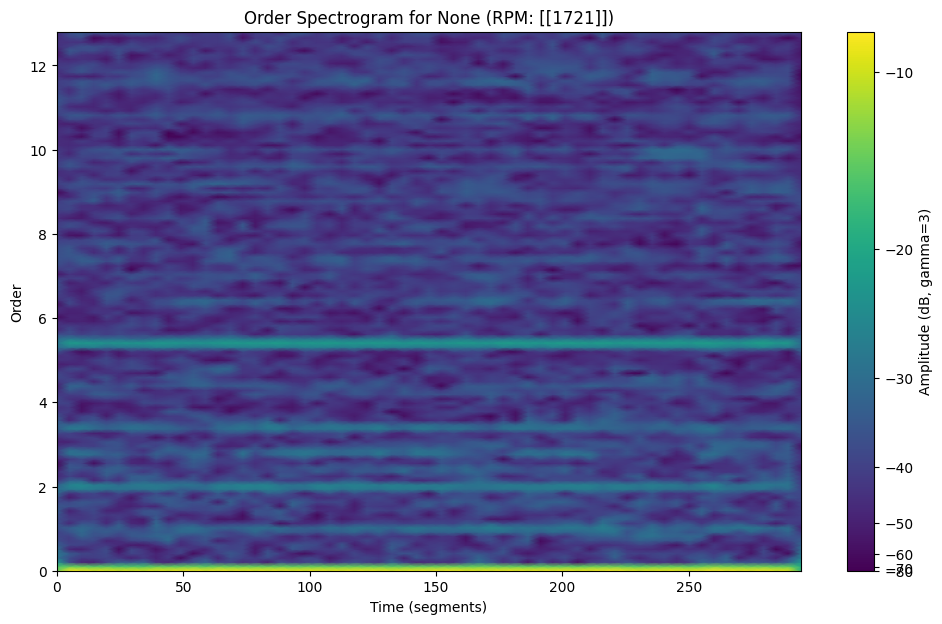

Loaded 121701 samples from 'None'
RPM: [[1728]], Label: -1
Dynamic nperseg calculated: 629
STFT matrix shape: (315, 61)


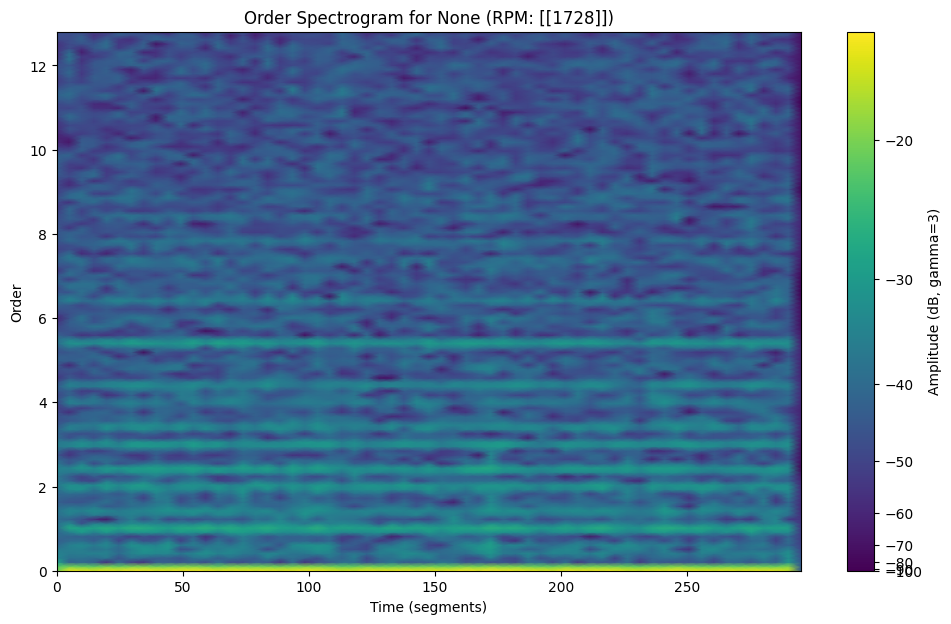

Loaded 121991 samples from 'None'
RPM: [[1728]], Label: -1
Dynamic nperseg calculated: 629
STFT matrix shape: (315, 61)


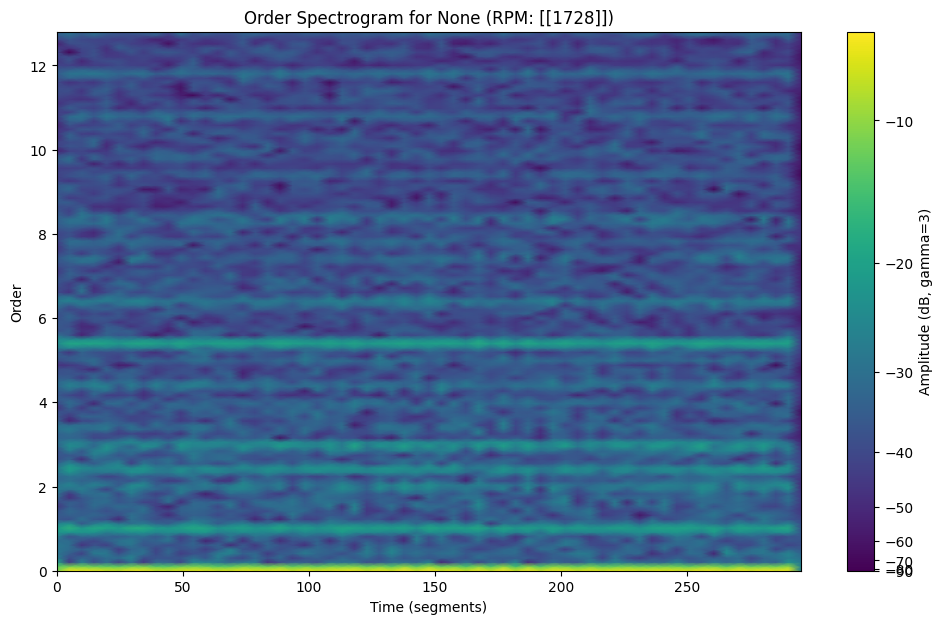

In [5]:
import numpy as np
import re
from pathlib import Path
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import hilbert, stft
import matplotlib.pyplot as plt

class CWRUDataLoader:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.fs = 12000
        self.n_rev = 64

        self.X = None
        self.Y = None
        self.rpm = None
        self.filename = None

    def get_label_from_path(self, file_path: Path) -> int:
        parent_dir_name = file_path.parent.name
        if 'Normal' in parent_dir_name: return 0
        elif 'B' in parent_dir_name: return 1
        elif 'IR' in parent_dir_name: return 2
        elif 'OR' in parent_dir_name: return 3
        return -1

    def import_cwru_data(self, 
        file_keys: list,
    ):

        base_path_obj = Path(self.base_path)

        for key in file_keys:        
            match = re.match(r'(\d+)(\w+)', key)      
            file_num_str, data_key = match.groups()

            glob_pattern = f'{file_num_str}_*.mat'
            found_files = list(base_path_obj.rglob(glob_pattern))   
            file_path = found_files[0]

            mat_data = loadmat(file_path)
            label = self.get_label_from_path(file_path)

            for key in mat_data.keys():
                if "RPM" in key:
                    rpm_key = key
                elif data_key in key:
                    mat_key = key

            time_series = mat_data[mat_key].flatten()

        self.rpm = mat_data[rpm_key]
        self.X = np.array(time_series)
        self.Y = label
        print(f"Loaded {len(self.X)} samples from '{self.filename}'")
        print(f"RPM: {self.rpm}, Label: {self.Y}")
        
        return self.X, self.Y
    
    def create_order_spectrogram(self, time_domain_window_len=4096, noverlap_ratio=0.5):
        """
        Tạo spectrogram bậc. Độ dài cửa sổ STFT (nperseg) được tính toán động
        để tương ứng với một cửa sổ có độ dài cố định trong miền thời gian.
        
        Args:
            time_domain_window_len (int): Độ dài cửa sổ mong muốn trong miền thời gian gốc.
            noverlap_ratio (float): Tỷ lệ chồng lấp cửa sổ STFT.
        """
        if self.X is None:
            raise RuntimeError("Data not loaded. Call import_cwru_data() first.")

        # --- Tính toán nperseg động ---
        fr = self.rpm / 60.0
        nperseg = int(np.round((time_domain_window_len / self.fs) * fr * self.n_rev))
        print(f"Dynamic nperseg calculated: {nperseg}")

        # --- Angular Resampling (Không đổi) ---
        t = np.arange(len(self.X)) / self.fs
        theta_t = 2 * np.pi * fr * t
        theta_t = np.squeeze(theta_t)
        total_revolutions = theta_t[-1] / (2 * np.pi)
        num_angle_samples = int(np.floor(total_revolutions * self.n_rev))
        theta_target = np.linspace(0, theta_t[-1], num_angle_samples, endpoint=False)
        interp_func = interp1d(theta_t, self.X, kind='cubic', bounds_error=False, fill_value=0)
        signal_angle_domain = interp_func(theta_target)

        # --- Envelope Extraction (Không đổi) ---
        envelope_signal = np.abs(hilbert(signal_angle_domain))

        # --- STFT với nperseg động ---
        noverlap = int(nperseg * noverlap_ratio)
        
        # Đảm bảo cửa sổ không dài hơn tín hiệu
        if nperseg > len(envelope_signal):
            print(f"Warning: nperseg ({nperseg}) is larger than the signal length ({len(envelope_signal)}). "
                  f"Using signal length as nperseg.")
            nperseg = len(envelope_signal)
            noverlap = 0

        orders, time_segments, stft_matrix = stft(
            envelope_signal,
            fs=self.n_rev,
            nperseg=nperseg,
            noverlap=noverlap
        )

        print(f"STFT matrix shape: {stft_matrix.shape}")
        return np.abs(stft_matrix), orders, time_segments

if __name__ == '__main__':
    data_loader = CWRUDataLoader("CWRU-dataset-main")

    file_list = [
                # "105DE", "106DE", "107DE","108DE",
                #  "169DE", "170DE", "171DE","171DE",
                #  "209DE", "210DE", "211DE","212DE",
                #  "130DE", "131DE", "132DE","133DE",
                #  "197DE", "198DE", "199DE","200DE",
                #  "234DE", "235DE", "236DE","237DE",
                #  "144DE", "145DE", "146DE","147DE",
                #  "156DE", "158DE", "159DE","160DE",
                #  "246DE", "247DE", "248DE","249DE",
                #  "258DE", "259DE", "260DE","261DE"
                "108DE",
                "172DE",
                "212DE",
                 ]
    for file in file_list:
        # File 2: ~1730 RPM
        X = data_loader.import_cwru_data([file]) # File này có RPM là 1730
        stft_matrix_2, orders_2, time_segments_2 = data_loader.create_order_spectrogram(
            time_domain_window_len=4096, 
            noverlap_ratio=0.5
        )

        gamma = 3
        plt.figure(figsize=(12, 7))
        stft_db = 20 * np.log10(stft_matrix_2 + 1e-9)
        plt.pcolormesh(time_segments_2, orders_2, stft_db, 
                shading='gouraud', 
                cmap='viridis',
                norm=colors.PowerNorm(gamma=gamma))

        plt.colorbar(label=f'Amplitude (dB, gamma={gamma})')
        plt.ylabel('Order')
        plt.xlabel('Time (segments)')
        plt.title(f'Order Spectrogram for {data_loader.filename} (RPM: {data_loader.rpm})')
        plt.ylim(0, data_loader.n_rev / 5)
        plt.show()
    

Loaded 122136 samples from 'None'
RPM: [[1797]], Label: -1


C:\Users\Admin\AppData\Local\Temp\ipykernel_28948\479142578.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nperseg = int(np.round((time_domain_window_len / self.fs) * fr * self.n_rev))


Dynamic nperseg calculated: 654
STFT matrix shape: (328, 61)


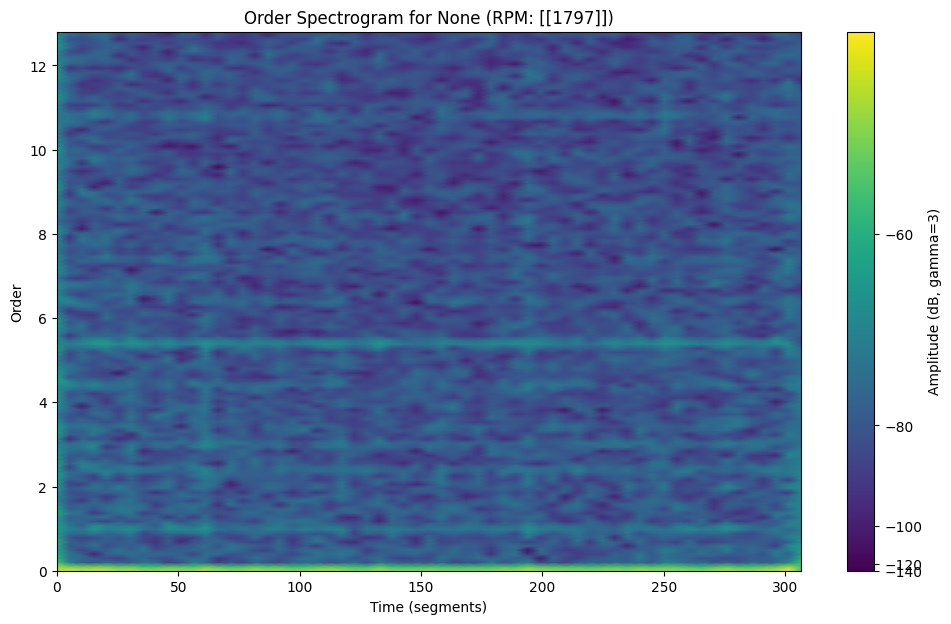

Loaded 121556 samples from 'None'
RPM: [[1774]], Label: -1
Dynamic nperseg calculated: 646
STFT matrix shape: (324, 61)


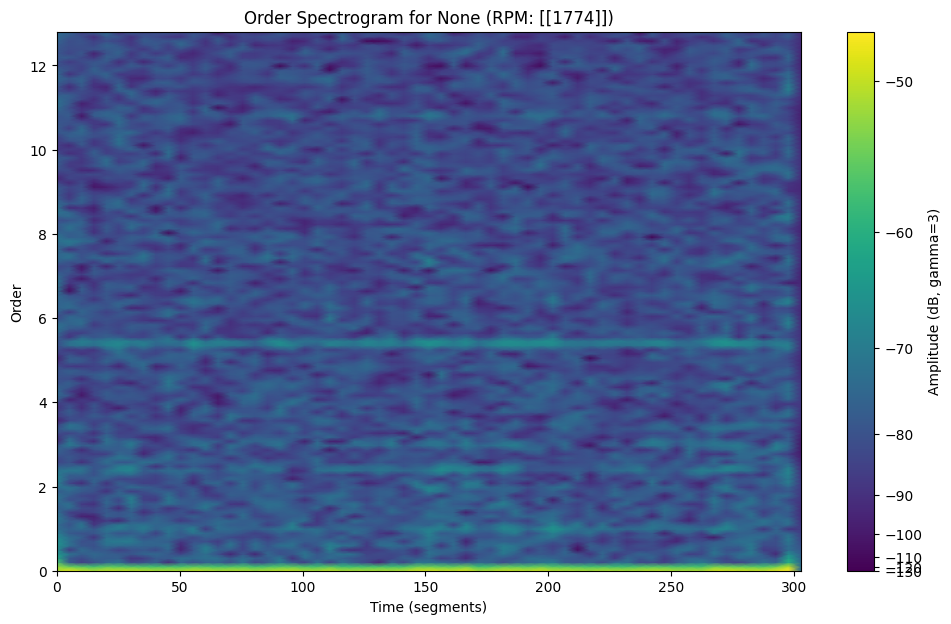

Loaded 121846 samples from 'None'
RPM: [[1752]], Label: -1
Dynamic nperseg calculated: 638
STFT matrix shape: (320, 61)


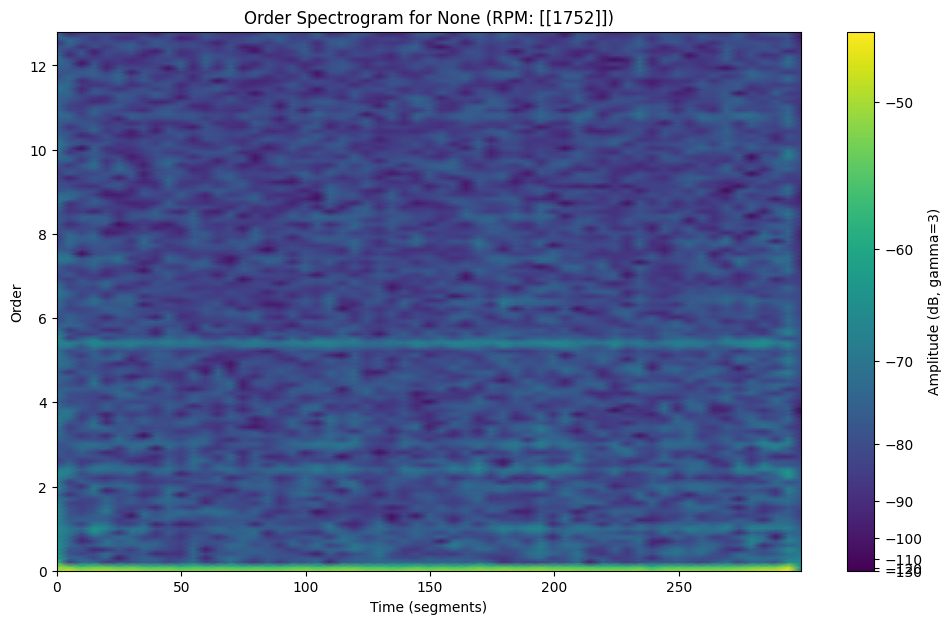

Loaded 121991 samples from 'None'
RPM: [[1728]], Label: -1
Dynamic nperseg calculated: 629
STFT matrix shape: (315, 61)


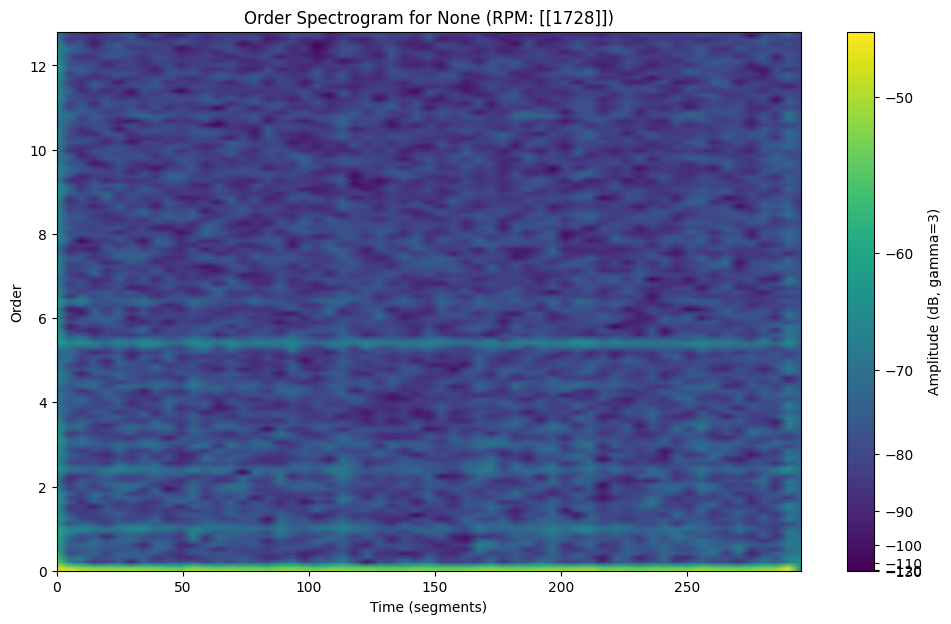

In [6]:
import numpy as np
import re
from pathlib import Path
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import hilbert, stft
import matplotlib.pyplot as plt

class CWRUDataLoader:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.fs = 12000
        self.n_rev = 64

        self.X = None
        self.Y = None
        self.rpm = None
        self.filename = None

    def get_label_from_path(self, file_path: Path) -> int:
        parent_dir_name = file_path.parent.name
        if 'Normal' in parent_dir_name: return 0
        elif 'B' in parent_dir_name: return 1
        elif 'IR' in parent_dir_name: return 2
        elif 'OR' in parent_dir_name: return 3
        return -1

    def import_cwru_data(self, 
        file_keys: list,
    ):

        base_path_obj = Path(self.base_path)

        for key in file_keys:        
            match = re.match(r'(\d+)(\w+)', key)      
            file_num_str, data_key = match.groups()

            glob_pattern = f'{file_num_str}_*.mat'
            found_files = list(base_path_obj.rglob(glob_pattern))   
            file_path = found_files[0]

            mat_data = loadmat(file_path)
            label = self.get_label_from_path(file_path)

            for key in mat_data.keys():
                if "RPM" in key:
                    rpm_key = key
                elif data_key in key:
                    mat_key = key

            time_series = mat_data[mat_key].flatten()

        self.rpm = mat_data[rpm_key]
        self.X = np.array(time_series)
        self.Y = label
        print(f"Loaded {len(self.X)} samples from '{self.filename}'")
        print(f"RPM: {self.rpm}, Label: {self.Y}")
        
        return self.X, self.Y
    
    def create_order_spectrogram(self, time_domain_window_len=4096, noverlap_ratio=0.5):
        """
        Tạo spectrogram bậc. Độ dài cửa sổ STFT (nperseg) được tính toán động
        để tương ứng với một cửa sổ có độ dài cố định trong miền thời gian.
        
        Args:
            time_domain_window_len (int): Độ dài cửa sổ mong muốn trong miền thời gian gốc.
            noverlap_ratio (float): Tỷ lệ chồng lấp cửa sổ STFT.
        """
        if self.X is None:
            raise RuntimeError("Data not loaded. Call import_cwru_data() first.")
        
        raw_signal = self.X
        fft_raw = np.fft.fft(raw_signal)
        phase_raw = np.angle(fft_raw)
        fft_whitened = np.exp(1j * phase_raw)
        signal_whitened = np.fft.ifft(fft_whitened).real

        # --- Tính toán nperseg động ---
        fr = self.rpm / 60.0
        nperseg = int(np.round((time_domain_window_len / self.fs) * fr * self.n_rev))
        print(f"Dynamic nperseg calculated: {nperseg}")

        # --- Angular Resampling (Không đổi) ---
        t = np.arange(len(self.X)) / self.fs
        theta_t = 2 * np.pi * fr * t
        theta_t = np.squeeze(theta_t)
        total_revolutions = theta_t[-1] / (2 * np.pi)
        num_angle_samples = int(np.floor(total_revolutions * self.n_rev))
        theta_target = np.linspace(0, theta_t[-1], num_angle_samples, endpoint=False)
        interp_func = interp1d(theta_t, signal_whitened, kind='cubic', bounds_error=False, fill_value=0)
        signal_angle_domain = interp_func(theta_target)

        # --- Envelope Extraction (Không đổi) ---
        envelope_signal = np.abs(hilbert(signal_angle_domain))

        # --- STFT với nperseg động ---
        noverlap = int(nperseg * noverlap_ratio)
        
        # Đảm bảo cửa sổ không dài hơn tín hiệu
        if nperseg > len(envelope_signal):
            print(f"Warning: nperseg ({nperseg}) is larger than the signal length ({len(envelope_signal)}). "
                  f"Using signal length as nperseg.")
            nperseg = len(envelope_signal)
            noverlap = 0

        orders, time_segments, stft_matrix = stft(
            envelope_signal,
            fs=self.n_rev,
            nperseg=nperseg,
            noverlap=noverlap
        )

        print(f"STFT matrix shape: {stft_matrix.shape}")
        return np.abs(stft_matrix), orders, time_segments

if __name__ == '__main__':
    data_loader = CWRUDataLoader("CWRU-dataset-main")

    file_list = [
                # "105DE", "106DE", "107DE","108DE",
                #  "169DE", "170DE", "171DE","171DE",
                 "209DE", "210DE", "211DE","212DE",
                #  "130DE", "131DE", "132DE","133DE",
                # #  "197DE", "198DE", "199DE","200DE",
                #  "234DE", "235DE", "236DE","237DE",
                #  "144DE", "145DE", "146DE","147DE",
                #  "156DE", "158DE", "159DE","160DE",
                #  "246DE", "247DE", "248DE","249DE",
                #  "258DE", "259DE", "260DE","261DE"
                 ]
    for file in file_list:
        # File 2: ~1730 RPM
        X = data_loader.import_cwru_data([file]) # File này có RPM là 1730
        stft_matrix_2, orders_2, time_segments_2 = data_loader.create_order_spectrogram(
            time_domain_window_len=4096, 
            noverlap_ratio=0.5
        )

        gamma = 3
        plt.figure(figsize=(12, 7))
        stft_db = 20 * np.log10(stft_matrix_2 + 1e-9)
        plt.pcolormesh(time_segments_2, orders_2, stft_db, 
                shading='gouraud', 
                cmap='viridis',
                norm=colors.PowerNorm(gamma=gamma))

        plt.colorbar(label=f'Amplitude (dB, gamma={gamma})')
        plt.ylabel('Order')
        plt.xlabel('Time (segments)')
        plt.title(f'Order Spectrogram for {data_loader.filename} (RPM: {data_loader.rpm})')
        plt.ylim(0, data_loader.n_rev / 5)
        plt.show()
    

In [2]:
import numpy as np
X = np.array([1,2])
X.shape

(2,)